In [1]:
!pip install torchinfo

In [2]:
train_dir = '../input/fruits/fruits-360-original-size/fruits-360-original-size/Training/'
test_dir = '../input/fruits/fruits-360-original-size/fruits-360-original-size/Validation/'

In [3]:
import os
import pandas as pd

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)

train_image_dirs = []
train_targets = []
cnt = 0
for d, dirs, files in os.walk(train_dir):
    if len(dirs) != 0:
        labels = dirs
    else:
        for i in files:
            train_image_dirs.append(d + '/' + i)
            train_targets.append(labels[cnt])
        cnt += 1
        
test_image_dirs = []
test_targets = []
cnt = 0
for d, dirs, files in os.walk(test_dir):
    if len(dirs) != 0:
        labels = dirs
    else:
        for i in files:
            test_image_dirs.append(d + '/' + i)
            test_targets.append(labels[cnt])
        cnt += 1
        
train_df = pd.DataFrame({'image_dirs': train_image_dirs,
                         'target': train_targets})
test_df = pd.DataFrame({'image_dirs': test_image_dirs,
                        'target': test_targets})

print(train_df.shape, test_df.shape)

train_df.head()

(6231, 2) (3114, 2)


,image_dirs,target
0,../input/fruits/fruits-360-original-size/fruit...,apple_red_delicios_1
1,../input/fruits/fruits-360-original-size/fruit...,apple_red_delicios_1
2,../input/fruits/fruits-360-original-size/fruit...,apple_red_delicios_1
3,../input/fruits/fruits-360-original-size/fruit...,apple_red_delicios_1
4,../input/fruits/fruits-360-original-size/fruit...,apple_red_delicios_1


In [4]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train_df['target'].values)
train_df['target'] = encoder.transform(train_df['target'].values)
test_df['target'] = encoder.transform(test_df['target'].values)
train_df.head()

,image_dirs,target
0,../input/fruits/fruits-360-original-size/fruit...,12
1,../input/fruits/fruits-360-original-size/fruit...,12
2,../input/fruits/fruits-360-original-size/fruit...,12
3,../input/fruits/fruits-360-original-size/fruit...,12
4,../input/fruits/fruits-360-original-size/fruit...,12


In [5]:
from torchvision import transforms

BATCH = 64
IMG_SIZE = 224
EPOCHS = 5
LR = 0.001

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [6]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchmetrics import F1Score

class CustomData(Dataset):
    def __init__(self, FNames, Labels, Transform):
        self.fnames = FNames
        self.transform = Transform
        self.labels = Labels         
        
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):       
        x = Image.open(self.fnames[index])
    
        if 'Training' or 'Test' in self.fnames[index]:             
            return self.transform(x), self.labels[index]
        elif 'Validation' in self.fnames[index]:            
            return self.transform(x), self.fnames[index]
                
trainset = CustomData(train_df['image_dirs'].values, train_df['target'].values, transform)
testset = CustomData(test_df['image_dirs'].values, test_df['target'].values, transform)

dataloaders = {'train': DataLoader(trainset, batch_size=BATCH, shuffle=True),
               'test': DataLoader(testset, batch_size=BATCH, shuffle=True)}

dataset_sizes = {'train': len(train_df),
                 'test': len(test_df)}

N_Classes = train_df['target'].nunique()
f1 = F1Score(num_classes=N_Classes, average="macro")

print(f'Количество классов: {N_Classes}')
print(f"Количество классов в валидационном множестве: {train_df['target'].nunique()}")
print(f"Размерность изображений в батче: {next(iter(dataloaders['test']))[0].shape}")

Количество классов: 24
Количество классов в валидационном множестве: 24
Размерность изображений в батче: torch.Size([64, 3, 224, 224])


In [7]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()
    best_model_wts = model.state_dict()
    best_f1 = 0.0
    losses = {'train': [], 'test': []}
    f1_macro = {'train': [], 'test': []}
    pbar = trange(num_epochs, desc='Epoch:')
    
    for epoch in pbar:
        
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train(True)
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            true_labels = []
            pred_labels = []
            
            for data in tqdm(dataloaders[phase], leave=False, desc=f'{phase} iter:'):
                inputs, labels = data
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels
                    
                if phase=='train':
                    optimizer.zero_grad()

                if phase == 'test':
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)
                true_labels +=  labels.tolist()
                pred_labels += outputs.tolist()

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.item()

            epoch_loss = running_loss / dataset_sizes[phase]
            f1_score = f1(torch.tensor(pred_labels), torch.tensor(true_labels))
            losses[phase].append(epoch_loss)
            f1_macro[phase].append(f1_score)
            
            pbar.set_description('{} Loss: {:.4f} F1: {:.4f}'.format(
                                    phase, epoch_loss, f1_score
                                ))
            
            if phase == 'test' and f1_score > best_f1:
                best_f1 = f1_score
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test f1_macro: {:4f}'.format(best_f1))

    model.load_state_dict(best_model_wts)
    return model, losses, f1_macro

In [8]:
from torchinfo import summary
from torchvision import models

resnet_model = models.resnet50(pretrained=True)
summary(resnet_model, input_size=(BATCH, 3, IMG_SIZE, IMG_SIZE))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 1000]                --
├─Conv2d: 1-1                            [64, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [64, 64, 112, 112]        128
├─ReLU: 1-3                              [64, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [64, 64, 56, 56]          --
├─Sequential: 1-5                        [64, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [64, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [64, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [64, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [64, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [64, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [64, 64, 56, 56]          --
│ 

In [9]:
vgg_model = models.vgg16(pretrained=True)
summary(vgg_model, input_size=(BATCH, 3, IMG_SIZE, IMG_SIZE))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [64, 1000]                --
├─Sequential: 1-1                        [64, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [64, 64, 224, 224]        1,792
│    └─ReLU: 2-2                         [64, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [64, 64, 224, 224]        36,928
│    └─ReLU: 2-4                         [64, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [64, 64, 112, 112]        --
│    └─Conv2d: 2-6                       [64, 128, 112, 112]       73,856
│    └─ReLU: 2-7                         [64, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [64, 128, 112, 112]       147,584
│    └─ReLU: 2-9                         [64, 128, 112, 112]       --
│    └─MaxPool2d: 2-10                   [64, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [64, 256, 56, 56]         29

In [10]:
# for param in resnet_model.parameters():
#     param.requires_grad = False
    
# for param in vgg_model.parameters():
#     param.requires_grad = False   

In [11]:
from tqdm.autonotebook import tqdm, trange
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import time

use_gpu = torch.cuda.is_available()

in_features = resnet_model.fc.in_features
resnet_model.fc = nn.Sequential(nn.Linear(in_features, 1024),
                                nn.ReLU(inplace=True),
                                nn.Linear(1024, 512),
                                nn.ReLU(inplace=True),
                                nn.Linear(512, N_Classes))

in_features = 25088
vgg_model.classifier = nn.Sequential(nn.Linear(in_features, 2048),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(2048, 512),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(512, N_Classes))

if use_gpu:
    resnet_model = resnet_model.cuda()
    vgg_model = vgg_model.cuda()

loss_fn = nn.CrossEntropyLoss()
resnet_optimizer_ft = optim.Adam(resnet_model.parameters(), lr=LR)
vgg_optimizer_ft = optim.Adam(vgg_model.parameters(), lr=LR)

In [12]:
resnet_model, resnet_losses, resnet_f1_macro = train_model(resnet_model, loss_fn, resnet_optimizer_ft, num_epochs=5)

Epoch::   0%|          | 0/5 [00:00<?, ?it/s]

train iter::   0%|          | 0/98 [00:00<?, ?it/s]

test iter::   0%|          | 0/49 [00:00<?, ?it/s]

train iter::   0%|          | 0/98 [00:00<?, ?it/s]

test iter::   0%|          | 0/49 [00:00<?, ?it/s]

train iter::   0%|          | 0/98 [00:00<?, ?it/s]

test iter::   0%|          | 0/49 [00:00<?, ?it/s]

train iter::   0%|          | 0/98 [00:00<?, ?it/s]

test iter::   0%|          | 0/49 [00:00<?, ?it/s]

train iter::   0%|          | 0/98 [00:00<?, ?it/s]

test iter::   0%|          | 0/49 [00:00<?, ?it/s]

Training complete in 10m 9s
Best test f1_macro: 0.993974


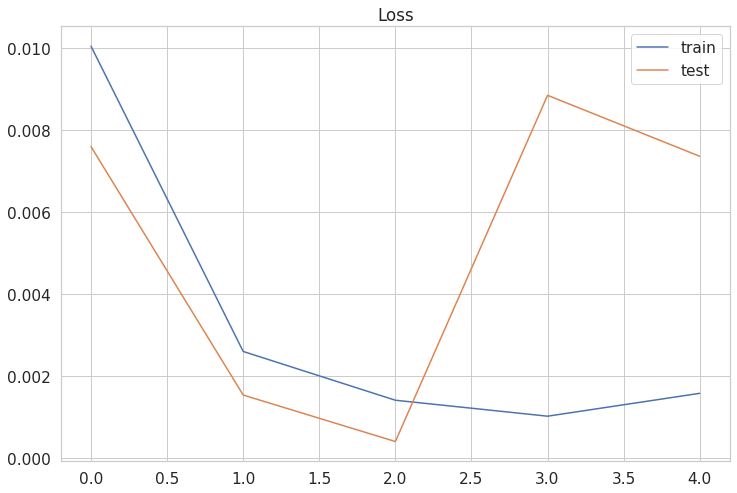

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(resnet_losses['train'], label="train")
plt.plot(resnet_losses['test'], label="test")
plt.title('Loss')
plt.legend()
plt.show()

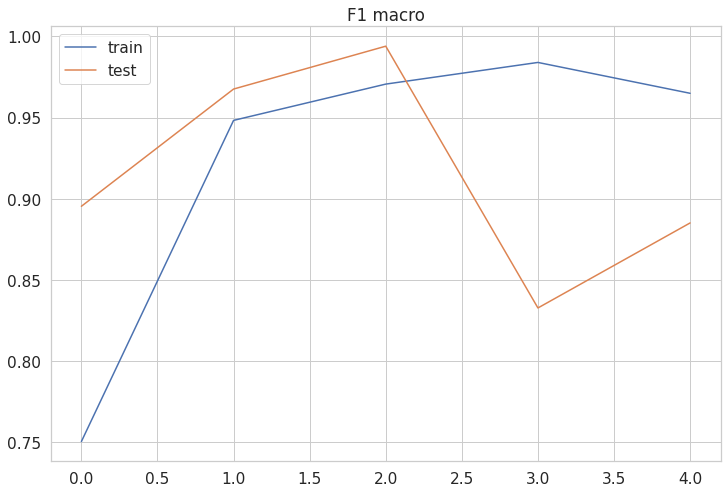

In [14]:
sns.set(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(resnet_f1_macro['train'], label="train")
plt.plot(resnet_f1_macro['test'], label="test")
plt.title('F1 macro')
plt.legend()
plt.show()

In [15]:
vgg_model, vgg_losses, vgg_f1_macro = train_model(vgg_model, loss_fn, vgg_optimizer_ft, num_epochs=5)

Epoch::   0%|          | 0/5 [00:00<?, ?it/s]

train iter::   0%|          | 0/98 [00:00<?, ?it/s]

test iter::   0%|          | 0/49 [00:00<?, ?it/s]

train iter::   0%|          | 0/98 [00:00<?, ?it/s]

test iter::   0%|          | 0/49 [00:00<?, ?it/s]

train iter::   0%|          | 0/98 [00:00<?, ?it/s]

test iter::   0%|          | 0/49 [00:00<?, ?it/s]

train iter::   0%|          | 0/98 [00:00<?, ?it/s]

test iter::   0%|          | 0/49 [00:00<?, ?it/s]

train iter::   0%|          | 0/98 [00:00<?, ?it/s]

test iter::   0%|          | 0/49 [00:00<?, ?it/s]

Training complete in 11m 19s
Best test f1_macro: 0.995252


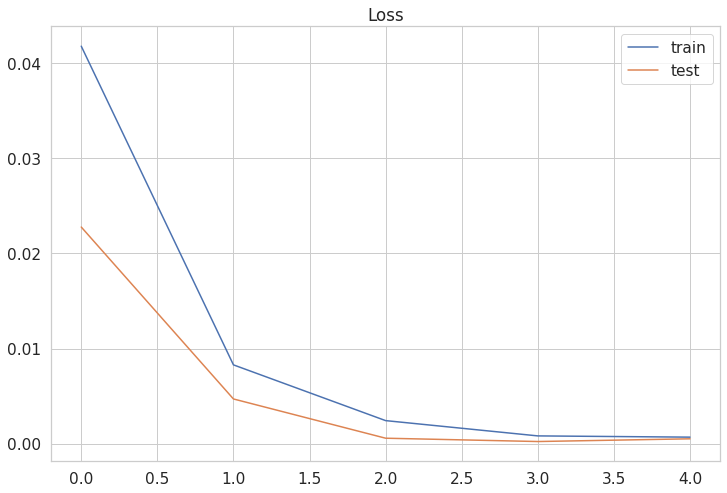

In [16]:
sns.set(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(vgg_losses['train'], label="train")
plt.plot(vgg_losses['test'], label="test")
plt.title('Loss')
plt.legend()
plt.show()

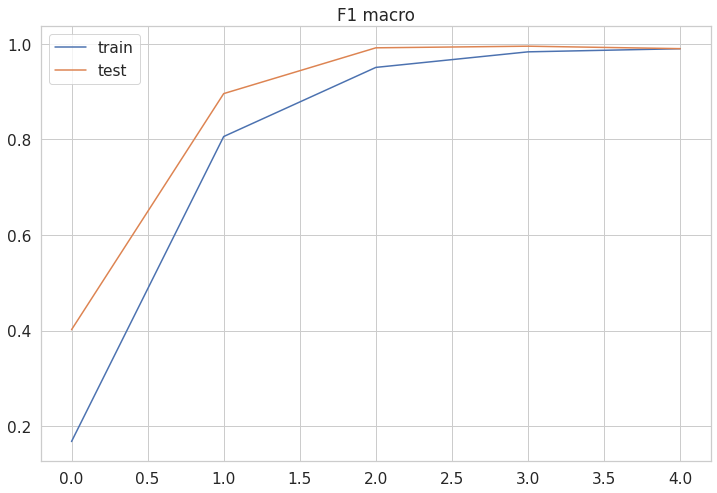

In [17]:
sns.set(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(vgg_f1_macro['train'], label="train")
plt.plot(vgg_f1_macro['test'], label="test")
plt.title('F1 macro')
plt.legend()
plt.show()

In [18]:
print('----------------- ResNet statistics -----------------')
pd.DataFrame({'train_loss': resnet_losses['train'],
             'test_loss': resnet_losses['test'], 
             'train_f1': resnet_f1_macro['train'], 
             'test_f1': resnet_f1_macro['test'], 
             })

----------------- ResNet statistics -----------------


,train_loss,test_loss,train_f1,test_f1
0,0.010046,0.007596,tensor(0.7505),tensor(0.8954)
1,0.002602,0.001539,tensor(0.9483),tensor(0.9676)
2,0.001412,0.000405,tensor(0.9706),tensor(0.9940)
3,0.001023,0.008848,tensor(0.9840),tensor(0.8328)
4,0.001581,0.007361,tensor(0.9650),tensor(0.8851)


In [19]:
print('----------------- VGG statistics -----------------')
pd.DataFrame({'train_loss': vgg_losses['train'],
             'test_loss': vgg_losses['test'], 
             'train_f1': vgg_f1_macro['train'], 
             'test_f1': vgg_f1_macro['test'], 
             })

----------------- VGG statistics -----------------


,train_loss,test_loss,train_f1,test_f1
0,0.041794,0.022779,tensor(0.1676),tensor(0.4016)
1,0.008287,0.004702,tensor(0.8061),tensor(0.8960)
2,0.002425,0.000576,tensor(0.9508),tensor(0.9918)
3,0.000818,0.000226,tensor(0.9834),tensor(0.9953)
4,0.000687,0.000513,tensor(0.9900),tensor(0.9901)


In [20]:
!mkdir models
!mkdir models/pytorch

In [22]:
torch.save(resnet_model.state_dict(), 'models/pytorch/resnet_weights.h5')
torch.save(vgg_model.state_dict(), 'models/pytorch/vgg_weights.h5')